# P2_AB_test_for_e-commerce_website

@by Hua 2020.05.17

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
## Introduction

- Data : `ab_data.csv`, `country.csv` (provided by Udacity Course)
- Description : For this project, I run the A/B test for an e-commerce website to understand if the company should implement the new page or keep the old page.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('./data/ab_data.csv');
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
np.sum(df.converted)/df.user_id.nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
a=df.shape[0]
b=df.query('landing_page=="new_page" and group =="treatment"').shape[0]
c=df.query('landing_page!="new_page" and group !="treatment"').shape[0]
a-b-c

3893

f. Finding missing values of the rows

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now create a new dataset called **df2** to store the right information.

In [8]:
df_treat=df.query('group=="treatment" and landing_page =="new_page"');
df_control=df.query('group=="control" and landing_page=="old_page"')
df2=pd.concat([df_treat, df_control], ignore_index=True)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Exploring **df2**

a. Unique **user_id**s in **df2**

In [10]:
df2.user_id.nunique()

290584

b. One **user_id** repeated in **df2**

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. The row information for the repeat **user_id**

In [12]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [13]:
df2.drop_duplicates('user_id',keep='first',inplace=True)

In [14]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** to do some calculation

a. The probability of an individual converting regardless of the page they receive

In [15]:
np.sum(df2.converted)/df2.user_id.nunique()

0.11959708724499628

b. Given that an individual was in the `control` group, find the probability they converted

In [16]:
df2.query('group=="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, find the probability they converted?

In [17]:
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

d. The probability that an individual received the new page

In [18]:
df2.query('landing_page=="new_page"').user_id.count()/df2.shape[0]

0.5000619442226688

e. Consider the results from a. through d. above, and check if there is sufficient evidence to say that the new treatment page leads to more conversions.

In [19]:
diffs=df2.query('group=="control"').converted.mean()-df2.query('group=="treatment"').converted.mean()
print('probability_difference = {}'.format(diffs))

probability_difference = 0.0015782389853555567


>**Brief summary**
>
>Since the probability difference is only 0.0015 which is too small, and the counts of group control and treatment are almost the same (propbability ~= 0.5), it's not sufficient to assert that new page leads to more conversions. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, let's technically run a hypothesis test continuously as each observation was observed.  

`1.` For now, to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, let's define the null and alternative hypotheses (in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.)

**Definition**

- null: **$p_{new}$** <= **$p_{old}$**
- alternative: **$p_{new}$** > **$p_{old}$**

`2.` Let's do the bootstrap (over 10,000 iterations) to see the p-value

In [20]:
p_diffs=[]
for i in range(10000):
    df_samp=df.sample(df.shape[0],replace=True)
    control_df=df_samp.query('group == "control"')
    treat_df=df_samp.query('group=="treatment"')
    p_old=control_df.converted.mean()
    p_new=treat_df.converted.mean()
    p_diffs.append(p_new-p_old)
    #print(i)

In [21]:
# observation
obs_diff=df2.query('group=="treatment"').converted.mean()-df2.query('group=="control"').converted.mean()

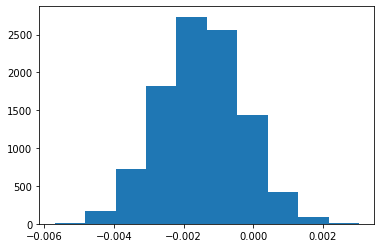

In [22]:
# the distribution of bootstrap
p_diffs=np.array(p_diffs)
plt.hist(p_diffs);

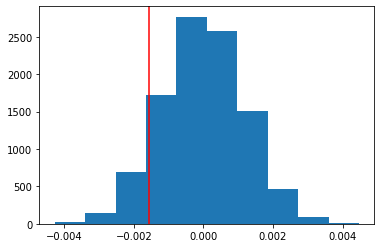

In [23]:
# generate a random normal distribution based on our bootstrap result
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red');
p_value=(null_vals > obs_diff).mean()

In [24]:
print('p-value ={}'.format(p_value))

p-value =0.9044


>**Brief summary.**
>
> Since our null hypothesis is **$p_{new}$** <= **$p_{old}$** , this value is high enough (90%) so that we won't reject the null hypothesis, which means new page doesn't lead higher conversions. (If the value is smaller than 0.1, then we can reject the null hypothesis.) 

`3.` Try the built-in modules

In [25]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').count()[0]
n_old = df2.query('landing_page == "old_page" ').count()[0]
n_new = df2.query('landing_page == "new_page" ').count()[0]

Using `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is the reference link.

In [26]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old], alternative='larger')
print('z-score={}'.format(z_score))
print('p-value={}'.format(p_value))

z-score=-1.3109241984234394
p-value=0.9050583127590245


>**Brief summary**
>
>- z-score means the distance (unit is standard deviation) from the mean (in this case, the difference of the two probabilities, which is =0). It can help to determine the p-value.
>- p-value is similar as the result of bootstrap method, which shows that we can't reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` Since each row is either a conversion or no conversion, I try the Logistic Regression in this final part.

In [27]:
# make column
df2['intercept']=1
df2[['control','ab_page']]=pd.get_dummies(df2.group)
df2.drop(labels=['control'],axis=1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


Using **statsmodels** to import regression model.  Instantiate the model, and fit the model using the two columns I've created to predict whether or not an individual converts.

In [28]:
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']]);
result=model.fit();

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [29]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 30 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        00:36:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [30]:
print('p-value={}'.format(result.pvalues))

p-value=intercept    0.000000
ab_page      0.189886
dtype: float64


>**Brief summary.**
>
>In our previous test in **Part II**, we've set
>
>- null: **$p_{new}$** <= **$p_{old}$**
>- alternative: **$p_{new}$** > **$p_{old}$**
>
>and get the p-value = 0.9.
>
>In logistic regression model, the p-value is assumed that
>
>- null  : $\beta=0$
>- alternative  : $\beta\neq0$
>
>where $\beta$ is the coefficients of the corresponding variables, and get the p-value = 0.19. Thus, in the logistic regression model, we can't reject the null hypothesis, which means the "ab_page" variable (treatment) is not statistically signigicant in predicting if it makes different conversions.
>
>**Therefore, these two kinds of p-value mean the same thing:
new_page does not lead to high conversions.**

`2.` Other factors and considerations could be input

Other factors:
- the gender, culture, habits, country of the customers
- the hardware/software the customers use

Addtional considerations
- They might correlated to each other
- The variable might has non-linear relationship (higher order)
- Have higher probability to get anomaly
- Reduce the overall quality of the data

`3.` Try the country information: `countries.csv`

In [31]:
# load data
countries_df = pd.read_csv('./data/countries.csv')
# join
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [32]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [33]:
### Create the necessary dummy variables
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [34]:
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country']) 

In [35]:
model=sm.Logit(df_new.converted,df_new[['intercept','CA','UK','ab_page']])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        00:36:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

I haved looked at the individual factors of country and page on conversion, let's now look at an interaction between page and country to see if there significant effects on conversion. 

In [36]:
### Fit Your Linear Model And Obtain the Results
df_new['page_US'] = df_new['ab_page'] * df_new['US']
df_new['page_CA'] = df_new['ab_page'] * df_new['CA'] 
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,page_US,page_CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [37]:
model = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US','ab_page','page_US','page_CA']])
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 30 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        00:36:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
page_US       -0.0314      0.027     -1.181      0.238      -0.084       0.021
page_CA       -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

<a id='conclusion'></a>
## Conclusion

- New page does not lead to higher conversions.
- Consider the Country factor, it is not statistically significant in predict if it makes different conversions.
- The interaction with country and page does not show the impact on the conversions.